In [1]:
# Header cell
from __future__ import division
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

# Specific things needed
import time
import math
import sys

# Add parent directory to path
sys.path.append('../code/')
sys.path.append('../sim/')

# Import deft modules
import deft_1d
import simulate_data_1d
import utils

In [26]:
# Simulate data
N = 300
data_type = 'wide'

# Simulate data and get default deft settings
data, defaults = simulate_data_1d.run(data_type,N)

In [27]:
# Deft parameter settings
G = 300
alpha = 3
bbox = [-6,6]

# Do density estimation
results = deft_1d.run(data, G=G, alpha=alpha, bbox=bbox, periodic=False, num_samples=0, print_t=False, tollerance=1E-3)

In [28]:
# Compute true density
xs = results.bin_centers
Q_true = np.zeros(G)
for i, x in enumerate(xs):
    Q_true[i] = eval(defaults['pdf_py'])
Q_true /= results.h*sum(Q_true)

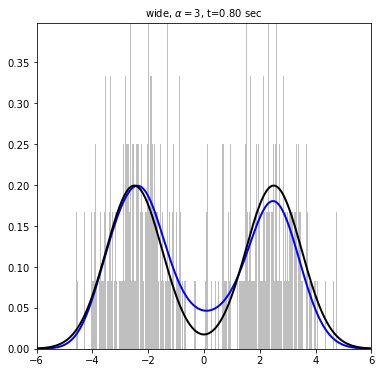

In [29]:
# Plot density estimate

# Make figure and set axis
plt.figure(figsize=[6, 6])
ax = plt.subplot(1,1,1)

# Plot histogram density
left_bin_edges = results.bin_edges[:-1]
plt.bar(left_bin_edges, results.R, \
    width=results.h, linewidth=0, color='gray', zorder=0, alpha=0.5)

# Plot deft density estimate
plt.plot(xs, results.Q_star, \
    color='blue', linewidth=2, alpha=1, zorder=2)

# Plot the true density
plt.plot(xs, Q_true, color='black', linewidth=2)

# Tidy up the plot
#plt.yticks([])
plt.ylim([0, 2*max(results.Q_star)])
plt.xlim(results.bbox)
t = results.deft_1d_compute_time
plt.title("%s, $\\alpha = %d$, t=%1.2f sec"%(data_type, alpha, t), \
    fontsize=10)

# Save plot
plt.savefig('report.test_deft_1d.png')

In [ ]:
# Derivative operator
L = results.G*results.h
h = L/G
delta_alpha_unitless=results.Delta.get_dense_matrix()
delta_alpha=delta_alpha_unitless/(h**(2*alpha))  # Give delta unites
Q_star = results.Q_star
phi_star = -np.log(Q_star) - np.log(L)
t_star = results.t_star
l_star = results.l_star 
PHI_STD_REG = utils.PHI_STD_REG
hessian = (h*l_star**(2*alpha)/L)*delta_alpha + (h*N/L)*np.diag(np.exp(-phi_star)) + (N/G)*np.eye(G)/(N*PHI_STD_REG**2) 
Q=np.linalg.eig(hessian)

# Compute spectrum
Q=np.linalg.eig(hessian)
e_vals = Q[0]
e_vecs = Q[1]

In [ ]:
# Define action
def S(x):
    x=np.mat(x)
    return (h*l_star**(2*alpha)/(2*L))*(x*delta_alpha*x.T)[0,0] \
            + (h*N*np.mat(results.R)*x.T)[0,0] \
            + (h*N/L)*np.sum(np.exp(-x)) \
            + (N/G)*0.5*(x*x.T)[0,0]/(N*PHI_STD_REG**2)
    
# Define test action
def S_test(x):
    x = np.mat(x)
    return 0.5*((x - phi_star) * hessian * (x - phi_star).T)[0,0]

In [ ]:
# MCMC sampling for S
# K is no. of metropolis iterations
K=3000
num_modes=G

# Initializing
step_vector = np.zeros(G)
phi_recorded = np.zeros((G,K))
phi_current = phi_star
acceptances = np.zeros(K)

for k in range(0,K):
    g=np.random.randint(0,num_modes)
    e_vec = Q[1][:,g].T 
    e_val = Q[0][g]
    step_length = np.random.normal(0,1.0/(np.sqrt(e_val)))
    step_vector = step_length * e_vec
    phi_new = phi_current + step_vector
    if np.random.uniform(0,1) < np.exp(S(phi_current)-S(phi_new)):   # P(phi_new)/P(phi_current):
        phi_current = phi_new
        acceptances[k] = 1
    phi_recorded[:,k] = phi_current

print 'Acceptance fraction = %f'%(1.0*acceptances.sum()/len(acceptances))

In [ ]:
# MCMC sampling for S_test

# Initializing
step_vector_test = np.zeros(G)
phi_recorded_test = np.zeros((G,K))
phi_current_test = phi_star
acceptances = np.zeros(K)
for k in range(0,K):
    g=np.random.randint(1,num_modes)
    e_vec = Q[1][:,g].T
    e_val = Q[0][g]
    step_length = np.random.normal(0,1.0/(np.sqrt(e_val)))
    step_vector_test = step_length * e_vec
    phi_new_test = phi_current_test + step_vector_test
    if np.random.uniform(0,1) < np.exp(S_test(phi_current_test)-S_test(phi_new_test)):
        phi_current_test = phi_new_test
        acceptances[k] = 1
    phi_recorded_test[:,k] = phi_current_test

print 'Acceptance fraction = %f'%(1.0*acceptances.sum()/len(acceptances))

In [ ]:
Ss_real = [S(phi_recorded[:,k]) - S(phi_star) for k in range(0,K)]
Ss_test = [S_test(phi_recorded[:,k]) - S_test(phi_star) for k in range(0,K)]
plt.plot(Ss_real,Ss_test,'.')
plt.xlabel('delta S_real')
plt.ylabel('delta S_test')
plt.title('S(phi_star) = %f'%S(phi_star))

Looks great! Now compare to Laplace Sampling

In [ ]:
Ss_real = [S(phi_recorded_test[:,k]) - S(phi_star) for k in range(K)]
Ss_test = [S_test(phi_recorded_test[:,k]) - S_test(phi_star) for k in range(K)]
plt.semilogx(Ss_real,Ss_test,'.')
plt.xlabel('delta S_real')
plt.ylabel('delta S_test')

In [ ]:
# Make heat plots of Qs from MCMC sampling of S and S_test
Qs = np.zeros([G,K])
Qs_test = np.zeros([G,K])
for k in range(K):
    phi = np.array(phi_recorded[:,k])
    Q_k = np.array(np.exp(-phi))/np.sum(h*np.array(np.exp(-phi)))
    phi_test = np.array(phi_recorded_test[:,k])
    Q_test_k = np.array(np.exp(-phi_test))/np.sum(h*np.array(np.exp(-phi_test)))
    Qs[:,k] = Q_k
    Qs_test[:,k] = Q_test_k
    
step_size=10
vmin=0
vmax=max(Q_star)
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(Qs[:,::step_size],interpolation='nearest',vmin=vmin,vmax=vmax,cmap='bone')
plt.subplot(1,2,2)
plt.imshow(Qs_test[:,::step_size],interpolation='nearest',vmin=vmin,vmax=vmax,cmap='bone')
plt.show()

In [ ]:
plt.figure(figsize=[8,8])
xs = results.bin_centers
# Plot histogram densitay
left_bin_edges = results.bin_edges[:-1]
plt.bar(left_bin_edges, results.R, \
    width=results.h, linewidth=0, color='gray', zorder=0, alpha=0.5)

# Plot deft density estimate
plt.plot(xs, Q_star, \
    color='blue', linewidth=2, alpha=1, zorder=2)

# Plot the true density
plt.plot(xs, Q_true, color='black', linewidth=2)

# Plot the MCMC samples from S
plt.plot(xs,Qs[:,np.random.choice(K,100)],'b',linewidth=.2,alpha=0.5)

# Plot MCMC samples from S_test
plt.plot(xs,Qs_test[:,np.random.choice(K,100)],'g',linewidth=.2,alpha=0.5)

# Tidy up the plot
#plt.yticks([])
plt.ylim([0, 1.2*max(results.Q_star)])
plt.xlim(results.bbox)
t = results.deft_1d_compute_time
plt.title("%s, $\\alpha = %d$, t=%1.2f sec"%(data_type, alpha, t), \
    fontsize=10)

In [ ]:
xs = np.linspace(-3,3,100)  # x-axis of plot
plt.figure(figsize=(16,16))
delta=np.zeros(100)
for m in range(1,9):
    plt.subplot(3,3,m)
    g=G-m  # choose eigenvector
    e_vec = Q[1][:,g].T
    e_val = Q[0][g]
    v = e_vec / np.sqrt(e_val)   # direction of perturbation
    dSs_real = np.zeros(len(xs))
    dSs_test = np.zeros(len(xs))
    for k,x in enumerate(xs):
        phi = phi_star + x*v
        dSs_real[k] = S(phi)-S(phi_star)
        dSs_test[k] = (S_test(phi)-S_test(phi_star))
        delta[k] = np.sqrt(dSs_real[k]**2 + dSs_test[k]**2)
    
    plt.plot(xs,dSs_test,'b',linewidth=3,alpha=.5)
    plt.plot(xs,dSs_real,'g',linewidth=3,alpha=.5)
    #plt.plot(xs,np.sqrt(dSs_test**2 + dSs_real**2),'r',linewidth=3,alpha=.5)
    plt.ylim([-0.5,max(dSs_test)])
    plt.title('m = %d'%m)
plt.show()
print delta
print delta[2]
sum(delta)/100.0

In [ ]:
data